In [2]:
import matplotlib.pyplot as plt
import numpy as numpy
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop

from google.colab import files

# Making and copying a smaller subset
import random
import shutil

# Fitting the model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
files.upload()

{}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 89% 107M/121M [00:00<00:00, 155MB/s] 
100% 121M/121M [00:00<00:00, 150MB/s]


In [ ]:
!unzip face-expression-recognition-dataset.zip


In [ ]:
!ls


face-expression-recognition-dataset.zip  images  kaggle.json  sample_data


In [ ]:
!ls folder-name


ls: cannot access 'folder-name': No such file or directory


In [ ]:
%cd /content


/content


In [ ]:

!ls


face-expression-recognition-dataset.zip  images  kaggle.json  sample_data


In [ ]:
!ls images


images	train  validation


In [ ]:
!ls train
!ls validation


ls: cannot access 'train': No such file or directory
ls: cannot access 'validation': No such file or directory


In [ ]:
%cd /images


[Errno 2] No such file or directory: '/images'
/content


In [ ]:
!ls images/train
!ls images/validation


angry  disgust	fear  happy  neutral  sad  surprise
angry  disgust	fear  happy  neutral  sad  surprise


In [ ]:
# Check in the first set of train and validation folders
print("first images")
!ls images/train
!ls images/validation

# Check in the nested train and validation folders
print("second images")
!ls images/images/train
!ls images/images/validation


first images
angry  disgust	fear  happy  neutral  sad  surprise
angry  disgust	fear  happy  neutral  sad  surprise
second images
angry  disgust	fear  happy  neutral  sad  surprise
angry  disgust	fear  happy  neutral  sad  surprise


In [ ]:
picture_size = 48
folder_path = "./images"

In [ ]:
full_train_set = "./images/train"
full_test_set = "./images/validation"

In [ ]:
# Function for making a testset - DIDN`T RUN FOR FINAL MODEL
def create_train_test_split(source_folder, train_folder, test_folder, test_split=0.15):
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    for expression in os.listdir(source_folder):
        source_expression_path = os.path.join(source_folder, expression)
        train_expression_path = os.path.join(train_folder, expression)
        test_expression_path = os.path.join(test_folder, expression)
        os.makedirs(train_expression_path, exist_ok=True)
        os.makedirs(test_expression_path, exist_ok=True)

        if os.path.isdir(source_expression_path):
            images = os.listdir(source_expression_path)
            random.shuffle(images)
            split_index = int(len(images) * (1 - test_split))
            train_images, test_images = images[:split_index], images[split_index:]

            for img in train_images:
                shutil.copyfile(os.path.join(source_expression_path, img), os.path.join(train_expression_path, img))
            for img in test_images:
                shutil.copyfile(os.path.join(source_expression_path, img), os.path.join(test_expression_path, img))


In [ ]:
# DIDN´T RUN FOR FINAL MODEL
create_train_test_split('images/train', 'new_train', 'new_val')

new_train = 'new_train'
new_val = 'new_val'


In [ ]:
# Funktion för att räkna filerna i undermapparna
def count_files_in_directory(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

train_count = count_files_in_directory(full_train_set)
val_count = count_files_in_directory(full_test_set)

print(f"Antal bilder i träningssetet: {train_count}")
print(f"Antal bilder i valideringssetet: {val_count}")


Antal bilder i träningssetet: 28821
Antal bilder i valideringssetet: 7066


In [ ]:
# Function for making a smaller subset of the dataset to work faster and more efficiently - DON´T RUN FOR THE FINAL MODEL.
def create_subset(source_folder, target_folder, num_samples_per_class):
    os.makedirs(target_folder, exist_ok=True)
    for expression in os.listdir(source_folder):
        source_expression_path = os.path.join(source_folder, expression)
        target_expression_path = os.path.join(target_folder, expression)
        os.makedirs(target_expression_path, exist_ok=True)

        if os.path.isdir(source_expression_path):
            images = os.listdir(source_expression_path)
            selected_images = random.sample(images, min(len(images), num_samples_per_class))

            for img in selected_images:
                src_path = os.path.join(source_expression_path, img)
                dst_path = os.path.join(target_expression_path, img)
                shutil.copyfile(src_path, dst_path)


In [ ]:
# DON´T RUN FOR FINAL MODEL
num_samples_per_class_train = 3000  # Antal bilder per klass
num_samples_per_class_val = int(3000*0.2) # konverterar till heltal


create_subset('new_train', 'small_train', num_samples_per_class_train)
create_subset('new_val', 'small_val', num_samples_per_class_val)


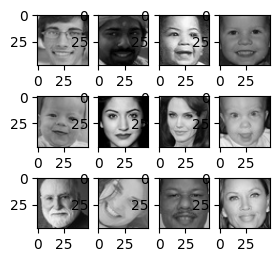

In [ ]:
expression = 'happy'
small_train_folder_path = full_train_set  # Uppdaterad sökväg

plt.figure(figsize=(3, 3))
for i in range(1, 13, 1):
    plt.subplot(3, 4, i)
    img_path = os.path.join(small_train_folder_path, expression, os.listdir(os.path.join(small_train_folder_path, expression))[i])
    img = load_img(img_path, target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()


## Train and test set


In [ ]:
batch_size = 128

datagen_train = ImageDataGenerator(rescale=1./255)  # Normalisera bilderna

    # rotation_range=10,  # Milda rotationer
    # width_shift_range=0.1,  # Milt horisontellt skift
    # height_shift_range=0.1,  # Milt vertikalt skift
    # shear_range=0.1,  # Mild shear transformation
    # zoom_range=0.1,  # Mild zoomning
    # horizontal_flip=True  # Horisontell vändning
# )

datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(full_train_set,
                                              target_size=(picture_size, picture_size),
                                              color_mode="rgb",
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              shuffle=True)

# val_set = datagen_test.flow_from_directory('new_val',
                                            # target_size=(picture_size, picture_size),
                                            # color_mode="grayscale",
                                            # batch_size=batch_size,
                                            # class_mode="categorical",
                                            # shuffle=False)

test_set = datagen_test.flow_from_directory(full_test_set,
                                           target_size=(picture_size, picture_size),
                                           color_mode="rgb",
                                           batch_size=batch_size,
                                           class_mode="categorical",
                                           shuffle=False)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


## Ändringar
Första:
- datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
) istället för bara datagen_train = ImageDataGenerator()
- batch_size = 100 istället för 128
- Dropout från 0.25 till 0.4
- model.add(GlobalAveragePooling2D()) istället för model.add(Flatten())
- (optimizer=Adam(lr=0.00005) istället för (optimizer=Adam(lr=0.0001)
- epochs = 12 istället för 48
- Resultat: Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
63/63 [==============================] - 233s 4s/step - loss: 1.9212 - accuracy: 0.2057 - val_loss: 1.9222 - val_accuracy: 0.2100 - lr: 0.0010
Epoch 8: early stopping



# Ändringar 2
- batch_size 150
- tillbaks tilll datagen_train = ImageDataGenerator() utan variationer
- Dropout 0.3
- tillbaka till Flatten()
- optimizer ändrad till opt = RMSprop(lr=0.0001)
- images = 2000 i train och (2000*0.2) i val
- Resultat: Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
82/82 [==============================] - 463s 6s/step - loss: 0.8325 - accuracy: 0.6896 - val_loss: 1.3965 - val_accuracy: 0.5042 - lr: 0.0010
Epoch 12: early stopping
- Träningstid ca 2-3 timmar

# Ändringar 3
- datagen_train = ImageDataGenerator(
    rotation_range=10,  # Milda rotationer
    width_shift_range=0.1,  # Milt horisontellt skift
    height_shift_range=0.1,  # Milt vertikalt skift
    shear_range=0.1,  # Mild shear transformation
    zoom_range=0.1,  # Mild zoomning
    horizontal_flip=True  # Horisontell vändning
)
- # 1st CNN layer
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(48, 48, 1)))  # Mindre antal filter
- lagt till ett till lager med 64 , ändrat kernel från (3, 3) till (4, 4)
- early stopping har patience=4 istället för 3
- epochs 20 istället för 12
- körning är med T4 GPU istället för CPU

# Ändringar 4
- Modellarkitekturen tillbaka till original
- har kvar denna från ändringar 3: datagen_train = ImageDataGenerator( rotation_range=10, # Milda rotationer width_shift_range=0.1, # Milt horisontellt skift height_shift_range=0.1, # Milt vertikalt skift shear_range=0.1, # Mild shear transformation zoom_range=0.1, # Mild zoomning horizontal_flip=True # Horisontell vändning )
- early stopping har patience=5 istället för 3
epochs 20 istället för 12
körning är med T4 GPU istället för CPU
- epochs 48
-batch_size 200
- den förbättrades för sakta, avbröt

# Ändringar 5
- Modellarkitekturen tillbaka till original
- datagen_train tillbaka utan variation
- early stopping har patience=5 istället för 3
epochs 20 istället för 12
körning är med T4 GPU istället för CPU
- epochs 48
-batch_size 200
Epoch 17: val_accuracy did not improve from 0.57667
76/76 [==============================] - 7s 94ms/step - loss: 0.6508 - accuracy: 0.7630 - val_loss: 1.2076 - val_accuracy: 0.5733 - lr: 4.0000e-05
Epoch 17: early stopping

# Resultat innan normalisering
-
-Epoch 21: val_accuracy improved from 0.63963 to 0.64105, saving model to ./model.h5
225/225 [==============================] - 14s 61ms/step - loss: 0.6067 - accuracy: 0.7768 - val_loss: 1.0405 - val_accuracy: 0.6411 - lr: 8.0000e-06
Epoch 22/48
225/225 [==============================] - ETA: 0s - loss: 0.5964 - accuracy: 0.7777Restoring model weights from the end of the best epoch: 17.


# Resultat efter normalisering
- Epoch 18: val_accuracy improved from 0.64034 to 0.64801, saving model to ./model.h5
225/225 [==============================] - 1183s 5s/step - loss: 0.5249 - accuracy: 0.8066 - val_loss: 1.0603 - val_accuracy: 0.6480 - lr: 4.0000e-05


# Resultat 2 efter normalisering
- Epoch 18: val_accuracy improved from 0.63864 to 0.64006, saving model to ./model.h5
225/225 [==============================] - 16s 69ms/step - loss: 0.5450 - accuracy: 0.7971 - val_loss: 1.0661 - val_accuracy: 0.6401 - lr: 4.0000e-05
Epoch 18: early stopping




In [ ]:
no_of_classes = 7

model = Sequential()

# 1st CNN layer
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 3)))  # Mindre antal filter
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

# 2nd CNN layer
model.add(Conv2D(128,(5, 5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

# 3rd CNN layer
model.add(Conv2D(512,(3, 3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
# Ändring: Global Average Pooling istället för Flatten
# model.add(GlobalAveragePooling2D())

# Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Fully connected 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(no_of_classes, activation='softmax'))

# opt = Adam(lr = 0.00005) # Ändring från 0.0001
# Ändring till RMSprop
opt = RMSprop(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

## Fitting the model

In [ ]:
checkpoint = ModelCheckpoint("./model.h5", monitor="val_accuracy", verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)

reduce_learningrate= ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=3,
                                         verbose=1,
                                         min_delta=0.0001)

callbacks_list= (early_stopping, checkpoint, reduce_learningrate)

epochs = 48

In [ ]:
history = model.fit_generator(generator=train_set,
                              steps_per_epoch=train_set.n//train_set.batch_size,
                              epochs=epochs,
                              validation_data=test_set,
                              validation_steps=test_set.n//test_set.batch_size,
                              callbacks=callbacks_list
                              )

Epoch 1/48


<ipython-input-23-2ab7b2a9fee0>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


225/225 [==============================] - ETA: 0s - loss: 1.7246 - accuracy: 0.3539
Epoch 1: val_accuracy improved from -inf to 0.14844, saving model to ./model.h5
225/225 [==============================] - 26s 74ms/step - loss: 1.7246 - accuracy: 0.3539 - val_loss: 1.8800 - val_accuracy: 0.1484 - lr: 0.0010
Epoch 2/48


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - ETA: 0s - loss: 1.3950 - accuracy: 0.4677
Epoch 2: val_accuracy improved from 0.14844 to 0.43764, saving model to ./model.h5
225/225 [==============================] - 15s 69ms/step - loss: 1.3950 - accuracy: 0.4677 - val_loss: 1.4651 - val_accuracy: 0.4376 - lr: 0.0010
Epoch 3/48
225/225 [==============================] - ETA: 0s - loss: 1.2626 - accuracy: 0.5178
Epoch 3: val_accuracy improved from 0.43764 to 0.51889, saving model to ./model.h5
225/225 [==============================] - 16s 69ms/step - loss: 1.2626 - accuracy: 0.5178 - val_loss: 1.2636 - val_accuracy: 0.5189 - lr: 0.0010
Epoch 4/48
225/225 [==============================] - ETA: 0s - loss: 1.1850 - accuracy: 0.5506
Epoch 4: val_accuracy improved from 0.51889 to 0.52969, saving model to ./model.h5
225/225 [==============================] - 16s 71ms/step - loss: 1.1850 - accuracy: 0.5506 - val_loss: 1.2393 - val_accuracy: 0.5297 - lr: 0.0010
Epoch 5/48
225/225 [================





## Resultat med original parametrar, 1000 bilder i train, (1000*0.2) i validation:
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
49/49 [==============================] - 222s 5s/step - loss: 1.1903 - accuracy: 0.5529 - val_loss: 1.8034 - val_accuracy: 0.3863 - lr: 0.0010
Epoch 7: early stopping

# SLUTLIGT RESULTAT FACE MODEL
Epoch 18: val_accuracy improved from 0.63864 to 0.64006, saving model to ./model.h5
225/225 [==============================] - 16s 69ms/step - loss: 0.5450 - accuracy: 0.7971 - val_loss: 1.0661 - val_accuracy: 0.6401 - lr: 4.0000e-05
Epoch 18: early stopping

# Plotting accuracy and loss

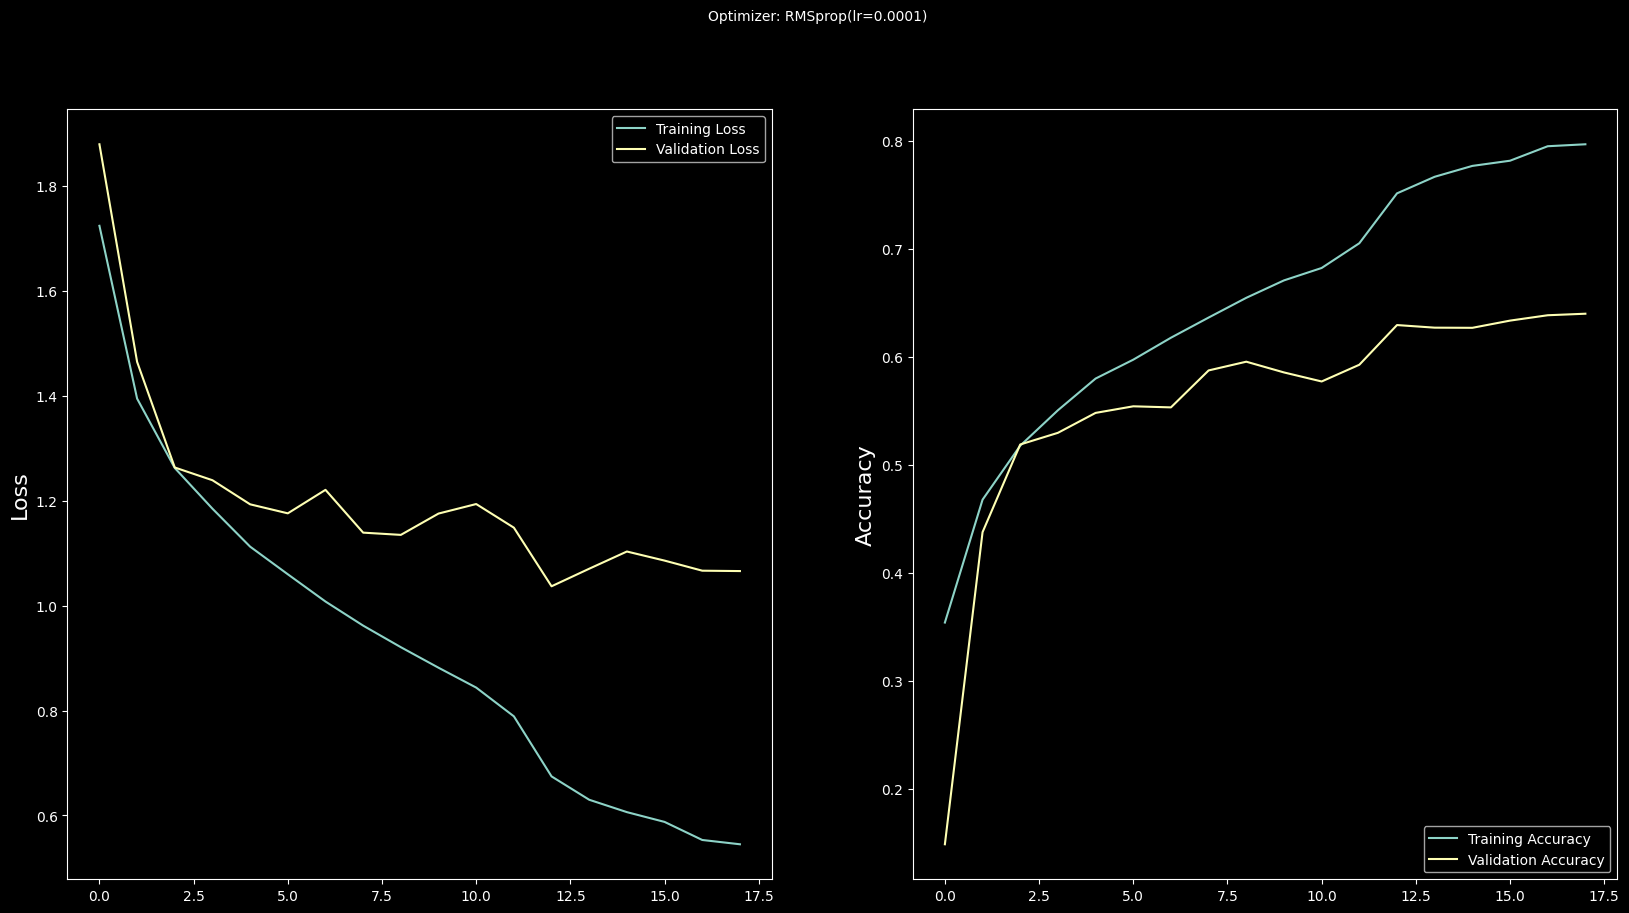

In [ ]:
plt.style.use("dark_background")

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer: RMSprop(lr=0.0001)', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# PART 2 - DEVELOPMENT - Hand model

In [3]:
import matplotlib.pyplot as plt
import numpy as numpy
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop

from google.colab import files

# Making and copying a smaller subset
import random
import shutil

# Fitting the model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"linneabackgard","key":"5acdeea07fec7c3b430898b0aec38aac"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the Sign Language MNIST Dataset
!kaggle datasets download -d datamunge/sign-language-mnist

# Unzip the Dataset
!unzip sign-language-mnist.zip


In [ ]:
!ls


american_sign_language.PNG  kaggle.json		     sign_mnist_test	  sign_mnist_train.csv
amer_sign2.png		    sample_data		     sign_mnist_test.csv
amer_sign3.png		    sign-language-mnist.zip  sign_mnist_train


In [7]:
%cd /content


/content


In [8]:

!ls


american_sign_language.PNG  kaggle.json		     sign_mnist_test	  sign_mnist_train.csv
amer_sign2.png		    sample_data		     sign_mnist_test.csv
amer_sign3.png		    sign-language-mnist.zip  sign_mnist_train


In [9]:
!ls sign_mnist_test.csv


sign_mnist_test.csv


# Load and split
- Splitting features and labels
- Splitting train into train and validation

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load datasets
train = pd.read_csv('./sign_mnist_train.csv')
test = pd.read_csv('./sign_mnist_test.csv')

# Split features and labels
train_labels = train['label']
train_images = train.drop('label', axis=1)
test_labels = test['label']
test_images = test.drop('label', axis=1)

# Split the training data into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# Waiting to convert to categorical (one hot encoding) to after plotting, and normalizing.

# EDA

In [11]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [12]:
train.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [14]:
train.shape

(27455, 785)

In [15]:
unique_classes = len(np.unique(train_labels))  # Use original_train_labels before one-hot encoding
print("Number of unique classes:", unique_classes)


Number of unique classes: 24


# Datasetet är lite obalanserat med den mest frekventa labeln som har 1033 st och den minst frekventa som har 755 st. Det är en skillnad av 278 st. Det finns tillräckligt antal i alla för att vara relevant och skillnaden är inte så stor så det borde vara acceptabelt, men kan visa sig i att modellen blir lite bättre på att känna igen de som finns fler antal av.

    Counts  Percentage
17    1033    4.703151
16     988    4.498270
14     977    4.448188
11     973    4.429976
22     971    4.420871
5      962    4.379894
19     956    4.352577
8      943    4.293389
13     942    4.288836
3      940    4.279730
23     934    4.252413
20     934    4.252413
18     928    4.225096
2      924    4.206884
24     911    4.147696
0      905    4.120379
10     895    4.074850
15     886    4.033874
21     885    4.029321
6      869    3.956474
12     823    3.747041
1      822    3.742488
7      808    3.678747
4      755    3.437443


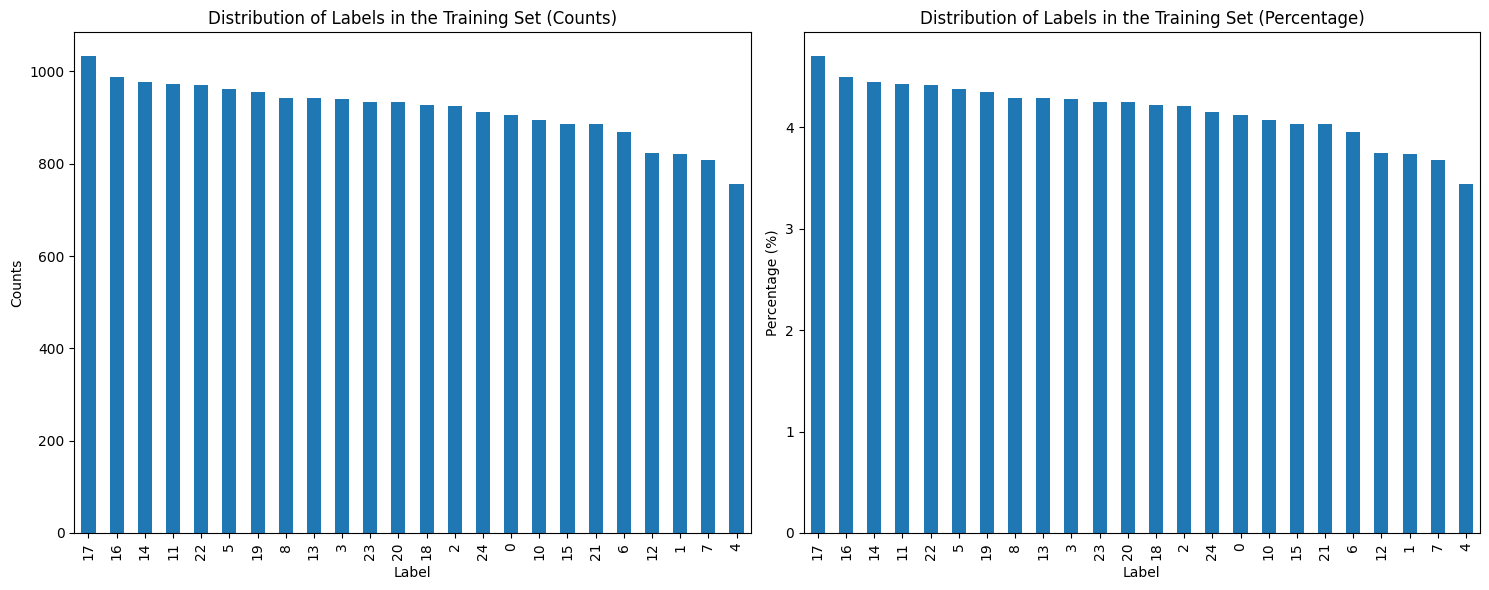

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_labels is already defined
# Count the occurrences of each label
label_counts = train_labels.value_counts()

# Calculate the percentage of each label
label_percentages = label_counts / len(train_labels) * 100

# Create a DataFrame for the counts and percentages
label_distribution = pd.DataFrame({'Counts': label_counts, 'Percentage': label_percentages})

# Display the label distribution
print(label_distribution)

# Plotting
plt.figure(figsize=(15, 6))

# Plot for the raw counts
plt.subplot(1, 2, 1)
label_counts.plot(kind='bar')
plt.title('Distribution of Labels in the Training Set (Counts)')
plt.xlabel('Label')
plt.ylabel('Counts')

# Plot for the percentages
plt.subplot(1, 2, 2)
label_percentages.plot(kind='bar')
plt.title('Distribution of Labels in the Training Set (Percentage)')
plt.xlabel('Label')
plt.ylabel('Percentage (%)')

plt.tight_layout()
plt.show()


In [ ]:
1033-755

278

# Preprocessing
- Normalizing
- Converting the images to categorical (one hot encoding)

The IndexError you're encountering occurs because there is still a label index of '24' in your dataset, which is out of bounds for a size of 24 classes (0 through 23). It seems that the label '9' (corresponding to the letter "J") is missing from the dataset, but the other labels are not shifted to fill this gap.

In [17]:

# Normalize and reshape the image data
train_images = np.array(train_images).reshape(-1, 28, 28, 1) / 255.0
val_images = np.array(val_images).reshape(-1, 28, 28, 1) / 255.0
test_images = np.array(test_images).reshape(-1, 28, 28, 1) / 255.0


In [18]:
num_classes = unique_classes

# Shift down labels greater than 9 by 1
train_labels_adj = np.where(train_labels > 9, train_labels - 1, train_labels)
val_labels_adj = np.where(val_labels > 9, val_labels - 1, val_labels)
test_labels_adj = np.where(test_labels > 9, test_labels - 1, test_labels)

# Verify the range of adjusted labels
print("Adjusted label range:", np.unique(train_labels_adj))

# Convert labels to categorical
train_labels_cat = to_categorical(train_labels_adj, num_classes)
val_labels_cat = to_categorical(val_labels_adj, num_classes)
test_labels_cat = to_categorical(test_labels_adj, num_classes)

# Check the shapes again
print("Shape of train_labels_cat:", train_labels_cat.shape)
print("Shape of val_labels_cat:", val_labels_cat.shape)
print("Shape of test_labels_cat:", test_labels_cat.shape)


Adjusted label range: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Shape of train_labels_cat: (21964, 24)
Shape of val_labels_cat: (5491, 24)
Shape of test_labels_cat: (7172, 24)


# Augmentation and defining model

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Clear the TensorFlow session
tf.keras.backend.clear_session()

# First augmentation


In [ ]:
# Create ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)


# Apply datagen to training data
datagen.fit(train_images)

# First hand model

In [ ]:


# Define the model
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(24, activation='softmax')
])

print("Shape of train_labels:", train_labels.shape)
print("Shape of val_labels:", val_labels.shape)


# Compile the model
model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Shape of train_labels: (21964,)
Shape of val_labels: (5491,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                             

# Callbacks

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint("sign_language_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

# EarlyStopping to stop training when the validation loss has not improved
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ReduceLROnPlateau to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001, verbose=1)

callbacks = [checkpoint, early_stopping, reduce_lr]


# Train the model

In [ ]:
# Train the model with data augmentation
history = model.fit(
    datagen.flow(train_images, train_labels_cat, batch_size=32),  # Use train_labels_cat
    epochs=20,
    validation_data=(val_images, val_labels_cat),  # Use val_labels_cat
    callbacks=callbacks
)



Epoch 1/20
687/687 [==============================] - ETA: 0s - loss: 3.1773 - accuracy: 0.0446
Epoch 1: val_accuracy improved from -inf to 0.04753, saving model to sign_language_model.h5
687/687 [==============================] - 13s 16ms/step - loss: 3.1773 - accuracy: 0.0446 - val_loss: 3.1777 - val_accuracy: 0.0475 - lr: 0.0010
Epoch 2/20
  4/687 [..............................] - ETA: 17s - loss: 3.1746 - accuracy: 0.0547

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


687/687 [==============================] - ETA: 0s - loss: 3.1763 - accuracy: 0.0466
Epoch 2: val_accuracy did not improve from 0.04753
687/687 [==============================] - 11s 15ms/step - loss: 3.1763 - accuracy: 0.0466 - val_loss: 3.1788 - val_accuracy: 0.0475 - lr: 0.0010
Epoch 3/20
686/687 [============================>.] - ETA: 0s - loss: 3.1763 - accuracy: 0.0470
Epoch 3: val_accuracy did not improve from 0.04753
687/687 [==============================] - 13s 19ms/step - loss: 3.1763 - accuracy: 0.0470 - val_loss: 3.1792 - val_accuracy: 0.0475 - lr: 0.0010
Epoch 4/20
686/687 [============================>.] - ETA: 0s - loss: 3.1761 - accuracy: 0.0466
Epoch 4: val_accuracy did not improve from 0.04753

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
687/687 [==============================] - 12s 18ms/step - loss: 3.1761 - accuracy: 0.0466 - val_loss: 3.1795 - val_accuracy: 0.0475 - lr: 0.0010
Epoch 5/20
685/687 [============================>.] - 

In [ ]:
plt.style.use("dark_background")

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer: RMSprop(lr=0.0001)', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Second hand model - all - code from notebook in kaggle
https://www.kaggle.com/code/okandeniz/sign-language-mnist-with-cnn

In [20]:
train.shape

(27455, 785)

In [1]:
# Load datasets
train = pd.read_csv('./sign_mnist_train.csv')
test = pd.read_csv('./sign_mnist_test.csv')

NameError: ignored

In [23]:
train.shape

(27455, 785)

In [24]:
Y_train=train["label"]
Y_test=test["label"]
X_train=train.drop(labels=["label"],axis=1)
X_test=test.drop(labels=["label"],axis=1)

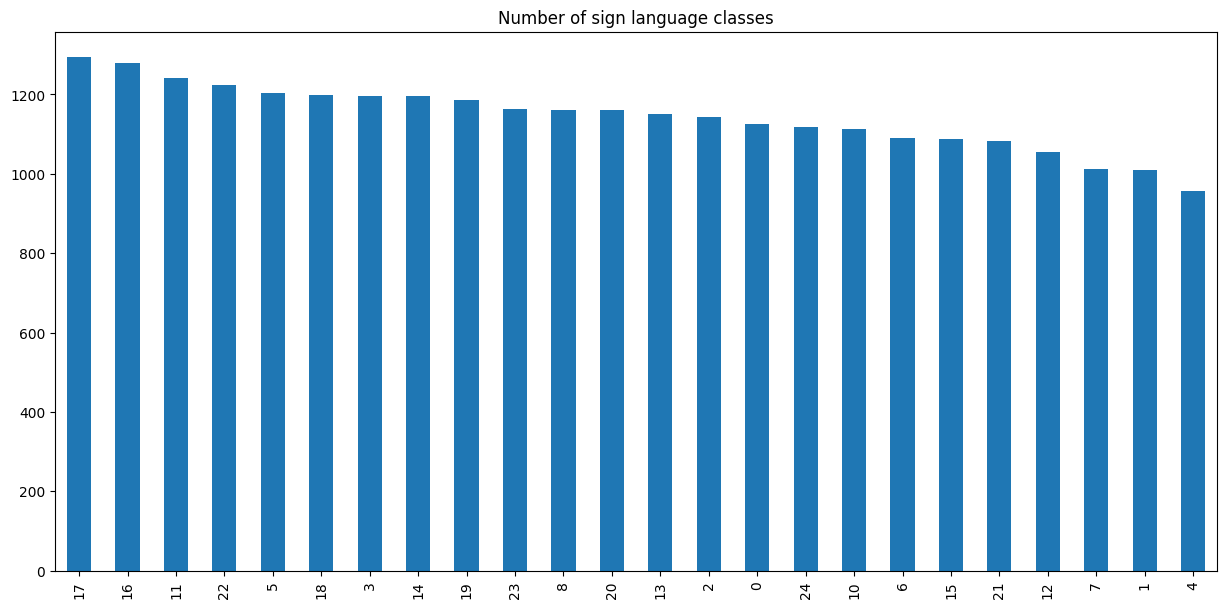

17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
3     1196
14    1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

In [25]:
# visiual number of Sign Language classes
plt.figure(figsize=(15,7))

Y_train.value_counts().sort_values(ascending=False).plot(kind="bar")
plt.title("Number of sign language classes")
plt.show()

Y_train.value_counts().sort_values(ascending=False)

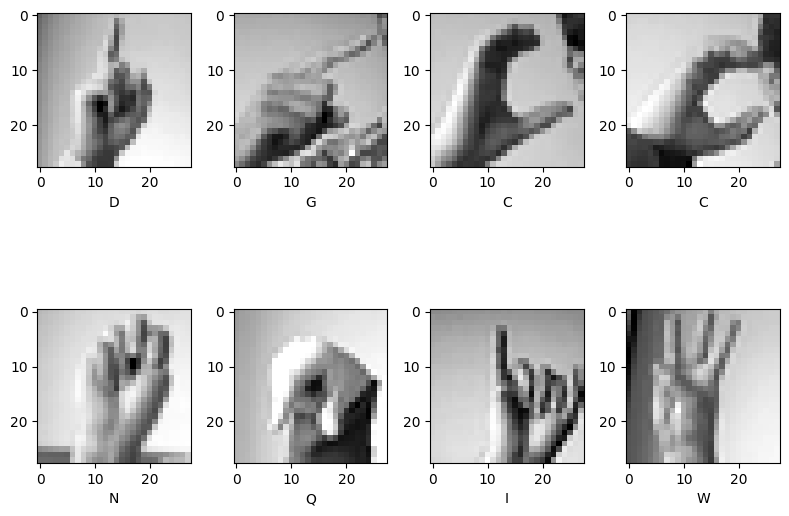

In [26]:
# plot some samples
f, ax=plt.subplots(2,4)
f.set_size_inches(8,8)

k=0
for i in range(2):
    for j in range(4):
        img=X_train.iloc[k].to_numpy()
        img=img.reshape((28,28))
        ax[i,j].set_xlabel(chr(Y_train[k]+65))
        ax[i,j].imshow(img,cmap="gray")
        k+=1
    plt.tight_layout()


In [27]:
# Normalize the data
# If we perform normalization, CNN works faster.

X_train=X_train/255.0
X_test=X_test/255.0
# We scaled image values between 0-255 to 0-1.


print("x_train shape: ",X_train.shape)
print("test shape: ",X_test.shape)


x_train shape:  (27455, 784)
test shape:  (7172, 784)


In [28]:
# Reshape
# We reshape all data to 28x28x1 3D matrices.
# Keras needs an extra dimension in the end which correspond to channels. Our images are gray scaled so it use only one channel.

X_train=X_train.values.reshape(-1,28,28,1)
X_test=X_test.values.reshape(-1,28,28,1)

print("x_train shape: ",X_train.shape)
print("test shape: ",X_test.shape)

x_train shape:  (27455, 28, 28, 1)
test shape:  (7172, 28, 28, 1)


In [29]:
# label encoding:
# Encode labels to one hot vectors
from sklearn.preprocessing import LabelBinarizer
label_binrizer = LabelBinarizer()
Y_train = label_binrizer.fit_transform(Y_train)

In [30]:
# Train Test Split

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)

print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (23336, 28, 28, 1)
x_test shape (4119, 28, 28, 1)
y_train shape (23336, 24)
y_test shape (4119, 24)


In [31]:
import tensorflow as tf
from tensorflow import keras

In [32]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

The channel sizes of feature maps gradually become larger and the size of feature maps gradually decreases.



# sign_language_model.h5 First try.

In [ ]:
model=Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), padding="Same",
                activation="relu", input_shape=(28,28,1))) # # We have 8 filters. (5x5)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="Same",
                activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
#

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="Same",
                activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connetcted
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(24,activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 32)         

# Second try hand model
- Skippar för har kört en gång men sen hann anslutningen brytas innan jag hann spara modellen och har inte tid att göra det igen

In [33]:
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
# from keras.optimizers import Adam

# Skapa en enklare modell
# model = Sequential()

# Första Convolutional Layer
# model.add(Conv2D(filters=32, kernel_size=(3,3), padding="Same",
                 activation="relu", input_shape=(28,28,1)))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# Andra Convolutional Layer
# model.add(Conv2D(filters=64, kernel_size=(3,3), padding="Same",
                 activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.25))

# Plattar till outputen och använder Dense Layers
# model.add(Flatten())
# model.add(Dense(128, activation="relu"))
# model.add(Dropout(0.25))
# model.add(Dense(24, activation="softmax"))  # Antal klasser är 24 (för ASL)

# Sammanfattning av modellen
# model.summary()

# Definiera optimeraren
# optimizer = Adam(lr=0.001)

# Kompilera modellen
# model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

In [ ]:
# Define the optimier
optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
# beta 1 and beta2 parameters are the parameters that affect the change of the learning rate.

In [ ]:
# Compile Model:
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [34]:
epochs=60 # for better result increase the epochs
batch_size=200

In [35]:
datagen=ImageDataGenerator(rotation_range=40, # Random rotation angle of images.
                          width_shift_range=0.2, # Horizontal and vertical scroll ratio of images
                          height_shift_range=0.2,
                          shear_range=0.2, # Sprain process
                          zoom_range=0.2, # rapprochement process
                          horizontal_flip=True, #  Rotate image vertically.
                          fill_mode='nearest') # scroll, rotate, etc. determines how to fill in the excess image points that appear after the process.

datagen.fit(X_train)

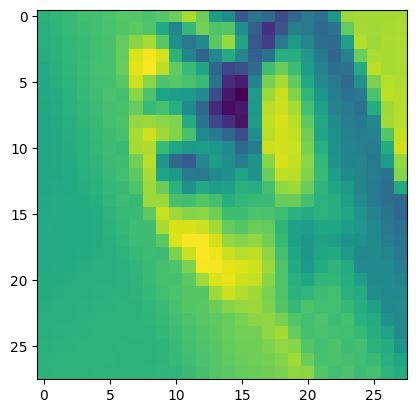

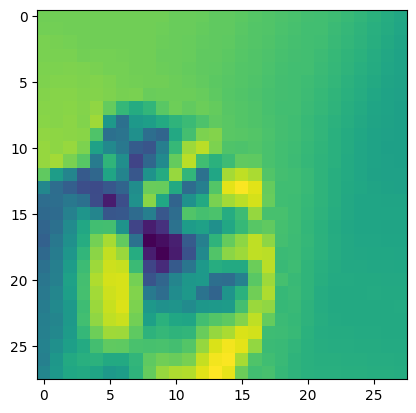

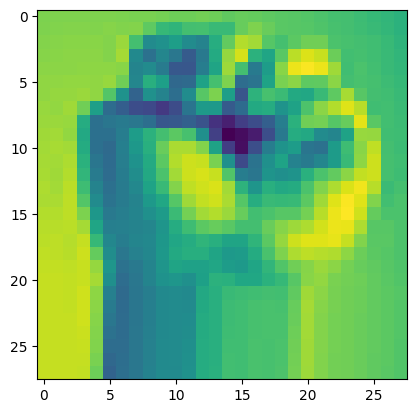

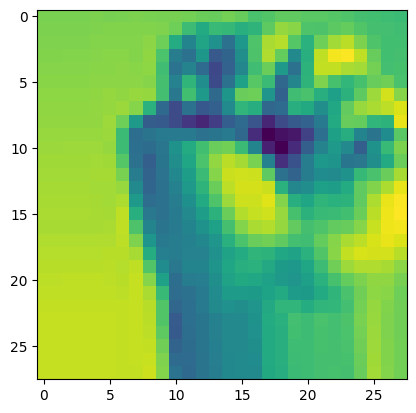

In [36]:
## Diversified Image
import keras.utils as image

a=X_train[0]
a=a.reshape((1,)+ a.shape)

i=0
for batch in datagen.flow(a,batch_size=1):
    plt.figure(i)
    imgplot=plt.imshow(image.array_to_img(batch[0]))
    i+=1
    if i%4==0:
        break
plt.show()

In [37]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint("sign_language_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

# EarlyStopping to stop training when the validation loss has not improved
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ReduceLROnPlateau to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

callbacks = [checkpoint, early_stopping, reduce_lr]


In [ ]:
history=model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size), epochs=epochs,
                           validation_data=(X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size,
                            callbacks=callbacks
                            )


Epoch 1/60
116/116 [==============================] - ETA: 0s - loss: 0.8811 - accuracy: 0.7023
Epoch 1: val_accuracy improved from -inf to 0.92959, saving model to sign_language_model.h5
116/116 [==============================] - 9s 74ms/step - loss: 0.8811 - accuracy: 0.7023 - val_loss: 0.2566 - val_accuracy: 0.9296 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/60
116/116 [==============================] - ETA: 0s - loss: 0.8583 - accuracy: 0.7057
Epoch 2: val_accuracy improved from 0.92959 to 0.93809, saving model to sign_language_model.h5
116/116 [==============================] - 8s 67ms/step - loss: 0.8583 - accuracy: 0.7057 - val_loss: 0.2205 - val_accuracy: 0.9381 - lr: 0.0010
Epoch 3/60
116/116 [==============================] - ETA: 0s - loss: 0.8451 - accuracy: 0.7174
Epoch 3: val_accuracy improved from 0.93809 to 0.94003, saving model to sign_language_model.h5
116/116 [==============================] - 10s 82ms/step - loss: 0.8451 - accuracy: 0.7174 - val_loss: 0.2138 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 4/60
116/116 [==============================] - ETA: 0s - loss: 0.8330 - accuracy: 0.7162
Epoch 4: val_accuracy did not improve from 0.94003
116/116 [==============================] - 9s 76ms/step - loss: 0.8330 - accuracy: 0.7162 - val_loss: 0.2227 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 5/60
116/116 [===============

In [38]:
# SECOND TRY
history=model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size), epochs=epochs,
                           validation_data=(X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size,
                            callbacks=callbacks
                            )


Epoch 1/60
116/116 [==============================] - ETA: 0s - loss: 3.1628 - accuracy: 0.0561
Epoch 1: val_accuracy improved from -inf to 0.11969, saving model to sign_language_model_2.h5
116/116 [==============================] - 16s 81ms/step - loss: 3.1628 - accuracy: 0.0561 - val_loss: 3.0382 - val_accuracy: 0.1197 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/60
116/116 [==============================] - ETA: 0s - loss: 2.9589 - accuracy: 0.1149
Epoch 2: val_accuracy improved from 0.11969 to 0.22433, saving model to sign_language_model_2.h5
116/116 [==============================] - 8s 66ms/step - loss: 2.9589 - accuracy: 0.1149 - val_loss: 2.6152 - val_accuracy: 0.2243 - lr: 0.0010
Epoch 3/60
116/116 [==============================] - ETA: 0s - loss: 2.7112 - accuracy: 0.1674
Epoch 3: val_accuracy improved from 0.22433 to 0.31755, saving model to sign_language_model_2.h5
116/116 [==============================] - 9s 76ms/step - loss: 2.7112 - accuracy: 0.1674 - val_loss: 2.2256 - val_accuracy: 0.3176 - lr: 0.0010
Epoch 4/60
116/116 [==============================] - ETA: 0s - loss: 2.4613 - accuracy: 0.2270
Epoch 4: val_accuracy improved from 0.31755 to 0.42437, saving model to sign_language_model_2.h5
116/116 [==============================] - 9s 74ms/step - loss: 2.4613 - accuracy: 0.2270 - val_loss: 1.8614 - val_accuracy: 0.4244

In [ ]:
history.history.keys()

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(25,10))
ax[0].plot(history.history["loss"],label="Training Loss")
ax[0].plot(history.history["val_loss"],label="Validation Loss")
ax[0].set_title("Loss Plot")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].legend()

ax[1].plot(history.history["accuracy"],label="Training accuracy")
ax[1].plot(history.history["val_accuracy"],label="Validation accuracy")
ax[1].set_title("Accuracy Plot")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()

plt.show()

In [ ]:
# confusion matrix
# Predict the values from validation dataset
Y_pred=model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes=np.argmax(Y_pred, axis=1)
# Convert validation observation to one hot vectors
Y_true=np.argmax(Y_val, axis=1)
# Compute the confusion matrix
confusion_mtx=confusion_matrix(Y_true,Y_pred_classes)
# plot confusion matrix
f,ax=plt.subplots(figsize=(15,12))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt=".1f", ax=ax)
plt.xlabel("Predict Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# For test data set:
Y_test = label_binrizer.fit_transform(Y_test)

Y_pred=model.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes=np.argmax(Y_pred, axis=1)
# Convert validation observation to one hot vectors
Y_true=np.argmax(Y_test, axis=1)
# Compute the confusion matrix
confusion_mtx=confusion_matrix(Y_true,Y_pred_classes)
# plot confusion matrix
f,ax=plt.subplots(figsize=(15,12))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt=".1f", ax=ax)
plt.xlabel("Predict Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
plt.figure(figsize=(25,25))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])
    plt.title("orginal : {} - predicted : {}".format(chr(Y_true[i]+65), chr(Y_pred_classes[i]+65)))
    plt.axis("off")